In [1]:
!pip install langgraph
!pip install langchain_community
!pip install bert-score
!pip install unbabel-comet

   ---------------------------------------- 0.0/819.3 kB ? eta -:--:--
   ------------ --------------------------- 262.1/819.3 kB ? eta -:--:--
   ---------------------------------------- 819.3/819.3 kB 4.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/529.7 kB ? eta -:--:--
   --------------------------------------- 529.7/529.7 kB 16.7 MB/s eta 0:00:00


In [3]:
import langchain
import langgraph
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage, AIMessage
import torch
from bert_score import score as bert_score
from comet import download_model, load_from_checkpoint
import os
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from typing import Annotated
from typing import TypedDict, List

In [4]:
class State(TypedDict):
    messages: List[HumanMessage]

In [5]:
# os.environ["OPENAI_API_KEY"] = "(발급받은 API 키)"
# OpenAI 모델 설정
llm = ChatOpenAI(model_name="gpt-4o", temperature=0, openai_api_key=os.getenv("OPENAI_API_KEY"))

C:\Users\201\AppData\Local\Temp\ipykernel_11468\1178519495.py:3: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model_name="gpt-4o", temperature=0, openai_api_key=os.getenv("OPENAI_API_KEY"))


In [6]:
def detect_intent(state: State) -> State:
    """ 사용자의 의도를 확인하는 함수 """
    system_prompt = "Is the user asking for a translation? Answer only 'yes' or 'no'."
    user_message = state["messages"][-1].content  # 마지막 메시지의 content만 추출
    response = llm([SystemMessage(content=system_prompt), HumanMessage(content=user_message)])
    print(response.content.strip())
    intent = response.content.strip().lower() == "yes"
    return {"messages": state["messages"] + [AIMessage(content=response.content)]}

In [7]:
def translate_text(state: State, target_language="ko") -> State:
    """ 텍스트를 번역하는 함수 """
    if "yes" in state["messages"][-1].content.lower():
        system_prompt = f"Translate the following text into {target_language}:"
        user_message = state["messages"][-2].content  # 원래 입력된 메시지
        response = llm([SystemMessage(content=system_prompt), HumanMessage(content=user_message)])
        return {"messages": state["messages"] + [AIMessage(content=response.content)]}
    return state

In [8]:
def condition_intent(state: State) -> str:
    return "translate" if "yes" in state["messages"][-1].content.lower() else END

In [10]:
# LangGraph Workflow
graph_builder = StateGraph(State)
graph_builder.add_node("intent_check", detect_intent)
graph_builder.add_node("translate", translate_text)
#graph_builder.add_node("end", END)

graph_builder.add_edge(START, "intent_check")
graph_builder.add_conditional_edges("intent_check", condition_intent)
graph_builder.add_edge("translate", END)

#graph_builder.set_entry_point(START)
graph = graph_builder.compile()

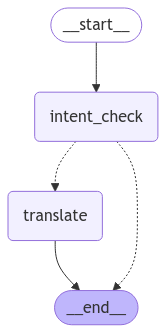

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [12]:
# 실행 예제
input_text = "배달의민족에서 야식을 추천해줘"
initial_state = {"messages": [HumanMessage(content=input_text)]}
result = graph.invoke(initial_state)
print("Final Result:", result["messages"][-1].content)

C:\Users\201\AppData\Local\Temp\ipykernel_11468\988853518.py:5: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm([SystemMessage(content=system_prompt), HumanMessage(content=user_message)])


no
Final Result: no


In [13]:
# 실행 예제
input_text = "다음을 영어로 번역해줄래? '배달의 민족에서 야식을 추천해줘'"
initial_state = {"messages": [HumanMessage(content=input_text)]}
result = graph.invoke(initial_state)
print("Final Result:", result["messages"][-1].content)

yes
Final Result: Please recommend a late-night snack from Baedal Minjok.
